In [ ]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [ ]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=ETC&tsym=CAD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [ ]:
hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 501 entries, 2020-06-06 to 2021-10-19
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   high              501 non-null    float64
 1   low               501 non-null    float64
 2   open              501 non-null    float64
 3   volumefrom        501 non-null    float64
 4   volumeto          501 non-null    float64
 5   close             501 non-null    float64
 6   conversionType    501 non-null    object 
 7   conversionSymbol  501 non-null    object 
dtypes: float64(6), object(2)
memory usage: 35.2+ KB


In [ ]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [ ]:
hist.head(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2020-06-06,9.530,9.407,9.420,3565297.62,33692230.08,9.450
2020-06-07,9.607,9.395,9.450,3840437.51,36145692.44,9.412
2020-06-08,9.375,9.174,9.412,3657752.71,33796386.65,9.240
2020-06-09,9.279,9.066,9.240,3523778.52,32118280.98,9.115
2020-06-10,9.306,9.070,9.115,1794836.97,16415934.13,9.146


In [ ]:
hist.head(-5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2020-06-06,9.530,9.407,9.420,3565297.62,3.369223e+07,9.450
2020-06-07,9.607,9.395,9.450,3840437.51,3.614569e+07,9.412
2020-06-08,9.375,9.174,9.412,3657752.71,3.379639e+07,9.240
2020-06-09,9.279,9.066,9.240,3523778.52,3.211828e+07,9.115
2020-06-10,9.306,9.070,9.115,1794836.97,1.641593e+07,9.146
...,...,...,...,...,...,...
2021-10-10,69.030,65.820,69.550,247615.43,1.630500e+07,65.850
2021-10-11,70.160,66.700,65.850,271222.62,1.830402e+07,67.490
2021-10-12,66.390,64.830,67.080,3136438.21,2.071351e+08,66.040


In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
train, test = train_test_split(hist, test_size=0.2)

In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(15, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('preço (Bitcoin)', fontsize=16)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=18);

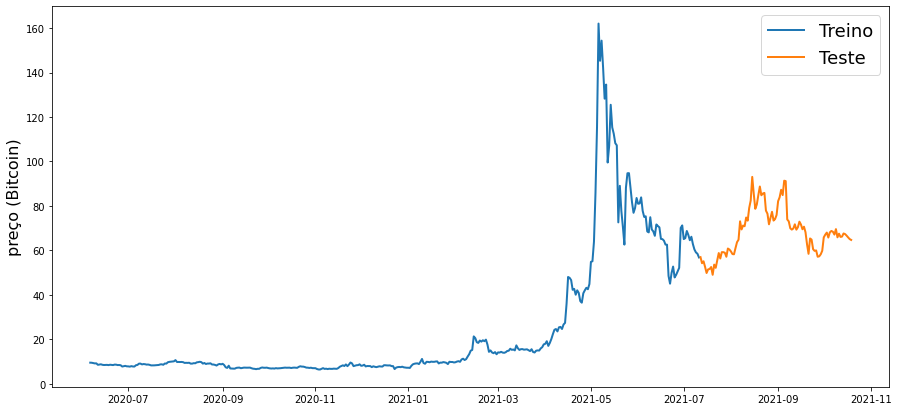

In [ ]:
line_plot(train[target_col], test[target_col], 'Treino', 'Teste', title='' )

In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [ ]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 70
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/70
13/13 [==============================] - 2s 40ms/step - loss: 0.0433 - val_loss: 0.0245
Epoch 2/70
13/13 [==============================] - 0s 8ms/step - loss: 0.0231 - val_loss: 0.0113
Epoch 3/70
13/13 [==============================] - 0s 8ms/step - loss: 0.0247 - val_loss: 0.0096
Epoch 4/70
13/13 [==============================] - 0s 8ms/step - loss: 0.0188 - val_loss: 0.0131
Epoch 5/70
13/13 [==============================] - 0s 8ms/step - loss: 0.0194 - val_loss: 0.0099
Epoch 6/70
13/13 [==============================] - 0s 8ms/step - loss: 0.0161 - val_loss: 0.0104
Epoch 7/70
13/13 [==============================] - 0s 9ms/step - loss: 0.0165 - val_loss: 0.0106
Epoch 8/70
13/13 [==============================] - 0s 7ms/step - loss: 0.0196 - val_loss: 0.0111
Epoch 9/70
13/13 [==============================] - 0s 8ms/step - loss: 0.0172 - val_loss: 0.0100
Epoch 10/70
13/13 [==============================] - 0s 8ms/step - loss: 0.0152 - val_loss: 0.0082
Epoch 11/70
13/13 

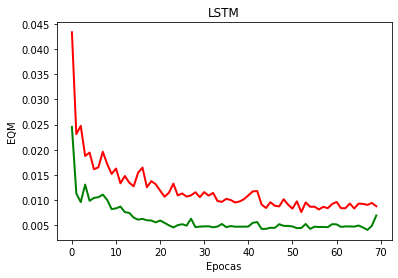

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epocas')
plt.ylabel('EQM')
plt.show()

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.05940900283987512

In [ ]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

0.006942569543921854

In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.3887592020096954

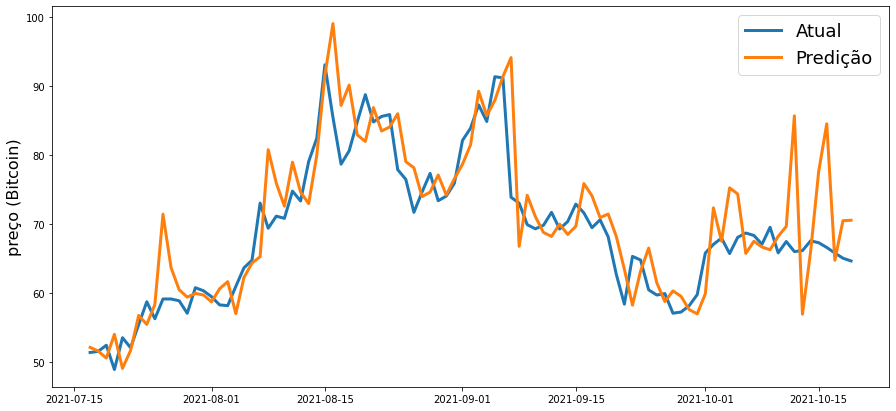

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'Atual', 'Predição', lw=3)